<a href="https://colab.research.google.com/github/ekunnii/APPIAN/blob/master/Kaggle/IFT6390_Classification_de_commentaires_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [0]:
!pwd

/content


### load data from Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/IFT6390_Kaggle/'
os.chdir(root_path)

#if Error: Transport endpoint is not connected
#go to Runtime --> Restart runtime

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data_train = np.load('data_train.pkl', allow_pickle=True)
data_test = np.load('data_test.pkl', allow_pickle=True)

In [0]:
df_test = pd.DataFrame({'message':data_test})
df_train = pd.DataFrame({'message':data_train[0],'subreddit': data_train[1]}  )
df_train.head()

,message,subreddit
0,"Honestly, Buffalo is the correct answer. I rem...",hockey
1,Ah yes way could have been :( remember when he...,nba
2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends
3,He wouldn't have been a bad signing if we woul...,soccer
4,Easy. You use the piss and dry technique. Let ...,funny


In [0]:
topic_count = df_train.groupby('subreddit').message.count()
topics = topic_count.index
## priors of the topic prob
priors = topic_count/df_train.shape[0]

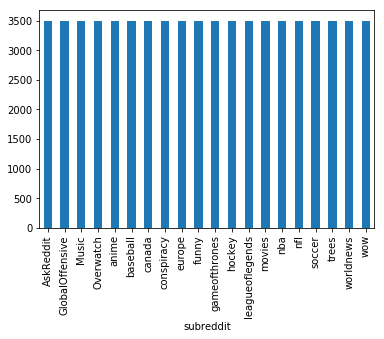

In [0]:
topic_count.plot.bar(ylim=0)
plt.show()

### Data Preprocessing using NLTK


In [0]:
import re
import nltk
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords


In [0]:
#dowload stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

#download punkt for word_tokensize
nltk.download('punkt')
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Toy example

In [0]:
# ## toy example of wordtokensize
# #https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# example_sent = "add 200 to fix programme 2xx yes is oh, passed, dps"

# # only keep word  
# word_tokens = re.sub("[^a-zA-Z]", " ", example_sent).split()  
# ## keep ponctuations and numbers
# # word_tokenize(example_sent) 

# # remove stop words
# stop_words = set(stopwords.words('english')) 
# filtered_sentence = [w for w in word_tokens if not w in stop_words] 

# # remove stemmers
# # https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# sentence = [stemmer.stem(w) for w in filtered_sentence]  # 
# sentence


### remove stopwords

In [0]:
def remove_stopwords(input_data):
    '''
    input_data: a vector of messages
    output: stopwords removed
    '''
    # required:
    # import nltk
    # dowload stopwords
    # nltk.download('stopwords')
    stop_words = set(stopwords.words('english')) 
    output = []
    for i, sentence in enumerate(input_data):
        #words = word_tokenize(sentence)  #will not remove punctuations and numbers
        sms = re.sub("[^a-zA-Z]", " ", sentence).lower()
        words = word_tokenize(sms)
        filtered_sentence = [w for w in words if not w in stop_words]
        output.append(" ".join(filtered_sentence).lower() )
    return output

    

### remove stemmers

In [0]:
def reduce_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

print(reduce_lengthening( "finallllllly" ) )

finally


In [0]:
def remove_stemmers(input_data):
    '''
    input: a vector of messages 
    output: remvove stemmers and punctuations
        all lower letter 
        stemmer removed
        punctuations removed
    '''
    ## require download punkt for word_tokensize
    #nltk.download('punkt')
    #stemmer = PorterStemmer()
    
    ## https://towardsdatascience.com/multi-class-text-classification-with-sklearn-and-nltk-in-python-a-software-engineering-use-case-779d4a28ba5
    ## df_train["cleaned"] = df_train['message'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
    output = []
    for i, sentence in enumerate(input_data):
        sms = re.sub("[^a-zA-Z]", " ", sentence) 
        words = word_tokenize(sms)
        filtered_sentence = [stemmer.stem(reduce_lengthening(w)) for w in words]
        output.append(" ".join(filtered_sentence) )
        
    return output

In [0]:
def messages_preprocess(input_data):      
    return remove_stemmers(remove_stopwords(input_data))

In [0]:
#preprocess df_train
start = time.time()

df_train['cleaned'] = messages_preprocess(df_train["message"])  #about 1 min

end = time.time()
print(end - start)
df_train.head()

66.68078351020813


,message,subreddit,cleaned
0,"Honestly, Buffalo is the correct answer. I rem...",hockey,honestli buffalo correct answer rememb peopl s...
1,Ah yes way could have been :( remember when he...,nba,ah ye way could rememb draft thought gon na gr...
2,https://youtu.be/6xxbBR8iSZ0?t=40m49s\n\nIf yo...,leagueoflegends,http youtu xxbbr isz find alreadi noth ordinar...
3,He wouldn't have been a bad signing if we woul...,soccer,bad sign paid euro right price would accept
4,Easy. You use the piss and dry technique. Let ...,funny,easi use piss dri techniqu let drop let dri ri...


# Naive Bayes with smoothing

In [0]:
from tokenize import tokenize

# extract all the words in the cleaned messages
def tokenize(sentences): 
    '''
    input: cleaned messages
    output: a list of unique vocabulary
    '''
    words = set()
    for sentence in sentences:
        sentence = sentence.split()
        for w in sentence:
            words.add(w)
    words = sorted(list(words))
    return words

# vocabulary in df_train
vocab = tokenize(df_train['cleaned'])
print('total vocabulary in training data = ', len(vocab))

total vocabulary in training data =  48911


In [0]:
def loglikelihood_topic(vocab, topic_sentences):
    '''
    vocab: vocabulary found in training data
    topic_sentences: cleaned column of messages
    output: list of loglikelihood of each word in the topic_sentences
    '''
    ######################################################################
    ######### HYPERPARAMETER ALPHA   #####################################
    ######################################################################
    alpha = 2
    count = [alpha for i in range(len(vocab))]
    dictionary = dict(zip(vocab, count))
    total_words = 0
    
    for idx, sentence in enumerate(topic_sentences):
        words = sentence.split()
        for w in words:
            total_words += 1
            dictionary[w] += 1
    
    #smoothing https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67

    prob = np.array(list(dictionary.values()))/(total_words + len(vocab)+1)
    return np.log(prob)


In [0]:
def loglikelihood_matrix(vocab, topics, df_train):
    '''
    return a matrix vocabulary*topics
    '''
    matrix = np.zeros((len(vocab), len(topics) ))
    for i, label in enumerate(topics):
        data = df_train['cleaned'][df_train['subreddit'] == label ]
        prob = loglikelihood_topic(vocab, data) 
        matrix[:,i] = prob 
        
    return matrix
        
m = loglikelihood_matrix(vocab, topics, df_train)  
m

array([[-11.06157871, -10.92043777, -11.48457743, ..., -10.89398554,
        -11.15817011, -11.11509365],
       [ -9.96296642, -10.51497266,  -9.77982934, ..., -10.20083836,
        -10.05955782, -10.70962854],
       [-11.06157871, -10.92043777, -11.48457743, ..., -10.89398554,
        -11.15817011, -11.11509365],
       ...,
       [-11.06157871, -10.92043777, -11.48457743, ..., -10.89398554,
        -10.752705  , -11.11509365],
       [-11.06157871, -10.51497266, -11.48457743, ..., -10.89398554,
        -11.15817011, -11.11509365],
       [-11.06157871, -10.92043777, -11.48457743, ..., -10.89398554,
        -11.15817011, -11.11509365]])

In [0]:
def predict_one(sentence):
    '''
    sentence: one cleaned sentence
    return a np.array with the log prob of each word in the sentence
    '''
    #count the occurence of the words, according to the vocab
    count = [0 for _ in vocab]
    for word in sentence.split():
        for i, voca in enumerate(vocab):
            if word == voca:
                count[i] += 1
    
    # f is the number of occurence of the word in the sentence
    log_f = np.log(np.array(count)+1)
    
    # priors of all the classes
    log_priors = np.log(np.array(priors))
    
    #log likelihood
    prob = np.dot(log_f.T, m) + log_priors
    
    return prob


def predict(allsentences):
    n = allsentences.shape[0]
    pred_labels = []
    count = 0
    for sentence in allsentences:
        count += 1
        #print(count)
        prob = predict_one(sentence)
        label = topics[np.argmax(prob)]
        pred_labels += [label]
    return pred_labels


# #test
# df_train0 = predict_one(df_train['cleaned'][8], vocab, m, priors)    
# indx = np.argmax(df_train0)
# topics[indx]

In [0]:
#test on training data

start = time.time()
pred_train = predict(df_train['cleaned'][:500])
end = time.time()
print(end - start)

same = 0 
for label,pred in zip(df_train['subreddit'], pred_train):
    if label == pred:
        same +=1
acc = same/500
acc

#alpa = 0.1 acc = 0.762 
#alpha =1 acc = 0.702
#alpha =2 acc = 0.68

85.50364756584167


0.68

## Predict for the test data on Kaggle

In [0]:
df_test.tail(10)

,message
29990,"Cersi never knew who it was, but never accused..."
29991,I said this before and I'll say it again. Midg...
29992,By responding to me you have just been baited ...
29993,"Ha, ok. Nice to see your football knowledge is..."
29994,What makes you think a Demiurge exists? Let al...
29995,I have no idea what's going on this trailer an...
29996,"I misread that at David Cross, and now I'm try..."
29997,Well lets be reasonable next time and dont unb...
29998,Jaime dumping on Jon for going off to serve in...
29999,"I think he'll be on par, but more mechanic tha..."


In [0]:
#preprocess df_test
start = time.time()

df_test['cleaned'] = messages_preprocess(df_test["message"])  #about 1 min

end = time.time()
print(end - start)
df_test.head()

28.302858114242554


,message,cleaned
0,Trout and Bryant have both led the league in s...,trout bryant led leagu strikeout trout actual ...
1,&gt; Just like Estonians have good reasons to ...,gt like estonian good reason fear russian expa...
2,Will Sol_Primeval sotp being oblivious?\n\nfin...,sol primev sotp oblivi find next episod
3,Moving Ostwald borders back to the pre 1967 bo...,move ostwald border back pre border declar pal...
4,"You have to take it out of the bag, Morty!",take bag morti


In [0]:
#test on test data
begin = 0
for i in range(5000,30001,5000):
    print(begin, i)
   
    start = time.time()
    pred_test = predict(df_test['cleaned'][begin:i])
    
    end = time.time()
    print(end - start)

    
    d = {'Id': range(begin,i), 'Category': pred_test}
    df = pd.DataFrame(d)
    file_name = "Oct12_alpha2" + str(begin)+".csv"
    df.to_csv(file_name)
    
    begin =i
